In [13]:
import jax
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from abmax.structs import Params
from matplotlib.patches import FancyArrowPatch

import seaborn as sns
sns.set_theme(style="darkgrid")
palette = "viridis"
sns.set_palette(palette)

RENDER_DATA_PATH = "./data/"
MAX_SPAWN_X = 500.0 # max x in spawning arena
MAX_SPAWN_Y = 500.0 # max y in spawning arena
GRASS_RADIUS = 5.0
SHEEP_RADIUS = 5.0
EP_LEN = 500
NUM_SHEEP = 100
NUM_GRASS = 100

In [14]:
def load_render_data(filenames):
    return {name: jnp.load(RENDER_DATA_PATH + fname) for name, fname in filenames.items()}

file_map = {
    'sheep_xs': 'rendering_sheep_xs.npy',
    'sheep_ys': 'rendering_sheep_ys.npy',
    'sheep_angs': 'rendering_sheep_angs.npy',
    'grass_xs': 'rendering_grass_xs.npy',
    'grass_ys': 'rendering_grass_ys.npy',
    'grass_energies': 'rendering_grass_energies.npy'
}

data = load_render_data(file_map)

In [15]:
print(*(f"{k}: {v.shape}" for k, v in data.items()))

sheep_xs: (10, 10, 500, 100, 1) sheep_ys: (10, 10, 500, 100, 1) sheep_angs: (10, 10, 500, 100, 1) grass_xs: (10, 10, 100) grass_ys: (10, 10, 100) grass_energies: (10, 10, 500, 100, 1)


In [16]:
def select_episode(data, env_idx, ep_idx):
    """Select a single environment and episode from the full dataset."""
    sheep_xs = jnp.squeeze(data['sheep_xs'][env_idx, ep_idx])
    sheep_ys = jnp.squeeze(data['sheep_ys'][env_idx, ep_idx])
    sheep_angs = jnp.squeeze(data['sheep_angs'][env_idx, ep_idx])

    grass_xs = data['grass_xs'][env_idx, ep_idx]
    grass_ys = data['grass_ys'][env_idx, ep_idx]
    grass_energies = jnp.squeeze(data['grass_energies'][env_idx, ep_idx])

    return {
        'sheep_xs': sheep_xs,
        'sheep_ys': sheep_ys,
        'sheep_angs': sheep_angs,
        'grass_xs': grass_xs,
        'grass_ys': grass_ys,
        'grass_energies': grass_energies
    }
env_idx, ep_idx = 0, 0
episode_data = select_episode(data, env_idx, ep_idx)

print(*(f"{k}: {v.shape}" for k, v in episode_data.items()))

sheep_xs: (500, 100) sheep_ys: (500, 100) sheep_angs: (500, 100) grass_xs: (100,) grass_ys: (100,) grass_energies: (500, 100)


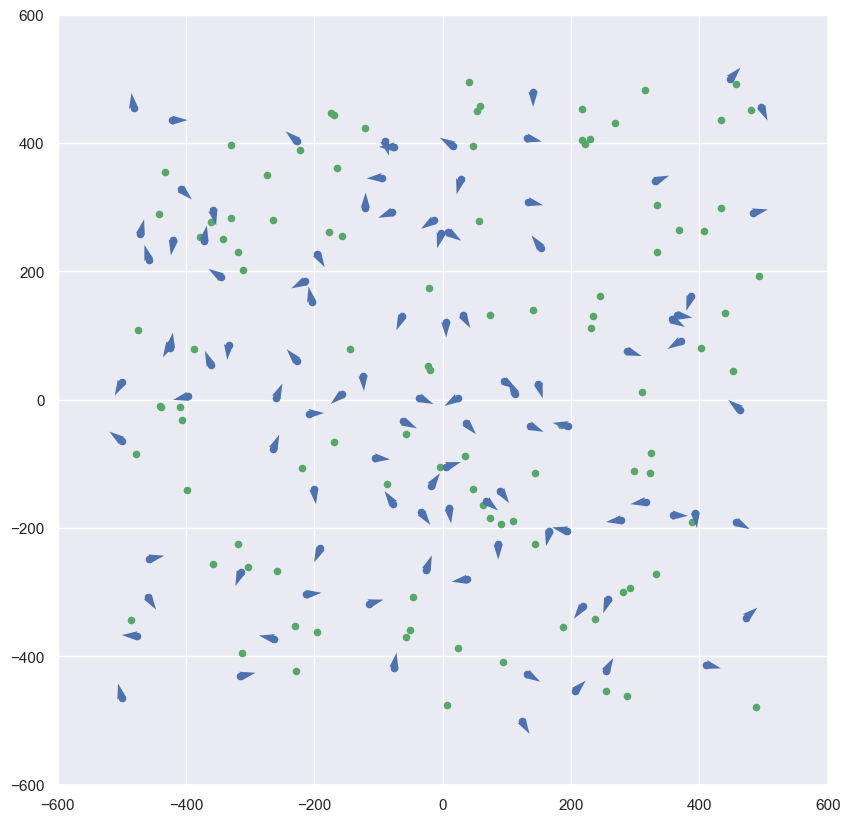

In [21]:
def render_one_traj(render_data):
    """Render a single trajectory of sheep and grass."""
    sheep_xs = render_data['sheep_xs']
    sheep_ys = render_data['sheep_ys']
    sheep_angs = render_data['sheep_angs']
    grass_xs = render_data['grass_xs']
    grass_ys = render_data['grass_ys']

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(-1.2 * MAX_SPAWN_X, 1.2 * MAX_SPAWN_X)
    ax.set_ylim(-1.2 * MAX_SPAWN_Y, 1.2 * MAX_SPAWN_Y)
    ax.set_aspect('equal')

    # Initial scatter plots
    grass_scatter = ax.scatter(grass_xs, grass_ys, c='g', s=GRASS_RADIUS*4)
    sheep_scatter = ax.scatter(sheep_xs[0], sheep_ys[0], c='b', s=SHEEP_RADIUS*4)
    sheep_quiver = ax.quiver(
        sheep_xs[0], sheep_ys[0],
        jnp.cos(sheep_angs[0]), jnp.sin(sheep_angs[0]),
        color='b', scale=50.0
    )

    # Update function for animation
    def update(frame):
        sheep_scatter.set_offsets(jnp.stack([sheep_xs[frame], sheep_ys[frame]], axis=-1))
        sheep_quiver.set_offsets(jnp.stack([sheep_xs[frame], sheep_ys[frame]], axis=-1))
        sheep_quiver.set_UVC(jnp.cos(sheep_angs[frame]), jnp.sin(sheep_angs[frame]))
        return sheep_scatter, sheep_quiver, grass_scatter

    ani = FuncAnimation(fig, update, frames=sheep_xs.shape[0], blit=True)
    ani.save('./pred_prey_scatter.mp4', writer='ffmpeg', fps=10)

# Render the selected episode
render_one_traj(episode_data)

In [25]:
# Extract data
sheep_xs = jnp.squeeze(data['sheep_xs'][env_idx, ep_idx]).T
sheep_ys = jnp.squeeze(data['sheep_ys'][env_idx, ep_idx]).T
sheep_angs = jnp.squeeze(data['sheep_angs'][env_idx, ep_idx]).T

grass_xs = data['grass_xs'][env_idx, ep_idx]
grass_ys = data['grass_ys'][env_idx, ep_idx]
grass_energies = jnp.squeeze(data['grass_energies'][env_idx, ep_idx]).T

print(sheep_xs.shape, sheep_ys.shape, sheep_angs.shape, grass_xs.shape, grass_ys.shape, grass_energies.shape)

# Initial positions (frame 0)
sheep_init_xs = sheep_xs[:, 0]
sheep_init_ys = sheep_ys[:, 0]
sheep_init_angs = sheep_angs[:, 0]
grass_init_energies = grass_energies[:, 0]

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(-MAX_SPAWN_X, MAX_SPAWN_X)
ax.set_ylim(-MAX_SPAWN_Y, MAX_SPAWN_Y)
ax.set_aspect('equal')
ax.tick_params(axis='both', which='major', labelsize=20)

# Scatter plots
grass_scatter = ax.scatter(grass_xs, grass_ys, c='g', s=GRASS_RADIUS*4, label='Grasses')
sheep_scatter = ax.scatter(sheep_init_xs, sheep_init_ys, c='b', s=SHEEP_RADIUS*4, label='Sheep')

# Quiver for sheep directions
sheep_quiver = ax.quiver(
    sheep_init_xs, sheep_init_ys,
    jnp.cos(sheep_init_angs), jnp.sin(sheep_init_angs),
    color='indigo', scale=80.0
)

# Create an invisible arrow patch for the legend
arrow_patch = FancyArrowPatch(
    (0, 0), (1, 0),
    color='indigo', alpha=0.0,
    mutation_scale=15,  # Arrow head size
    linewidth=1.5,
    arrowstyle='->',
    label='Sheep directions'
)

# Legend
ax.legend(
    [grass_scatter, sheep_scatter, arrow_patch],
    ['Grasses', 'Sheep', 'Sheep directions'],
    loc='upper left', fontsize=18
)

# Save figure
plt.savefig('./pred_prey_scatter.svg', bbox_inches='tight')
plt.close(fig)

(100, 500) (100, 500) (100, 500) (100,) (100,) (100, 500)
